In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (10, 8)

import os
import numpy as np
from glob import glob
import pydicom
import subtle.utils.io as suio
import subtle.utils.experiment as exp_utils
import subtle.subtle_preprocess as supre
import SimpleITK as sitk
from QC.util.aliasing_sim import AliasingLayer
from scipy.ndimage.interpolation import rotate
import torchio as tio
import pandas as pd
from tqdm import tqdm
import json

def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

def get_pixel_spacing(hdr):
    return np.array([float(hdr.PixelSpacing[0]), float(hdr.PixelSpacing[1]), float(hdr.SliceThickness)])

def combine_stat_csvs():
    df_stats_rng = pd.read_csv('/home/srivathsa/projects/studies/gad/gad_2d/data/aug/ring/sim_stats.csv', index_col=0)
    df_stats_mot = pd.read_csv('/home/srivathsa/projects/studies/gad/gad_2d/data/aug/motion/sim_stats.csv', index_col=0)
    df_stats_both = pd.read_csv('/home/srivathsa/projects/studies/gad/gad_2d/data/aug/both/sim_stats.csv', index_col=0)

    df_aug = pd.concat([df_stats_rng, df_stats_mot, df_stats_both])
    
    aug_cases = sorted(df_aug['Case'].tolist())
    all_cases = sorted([f.split('/')[-1] for f in glob('/home/srivathsa/projects/studies/gad/gad_2d/data/clean/*')])
    clean_cases = [c for c in all_cases if c not in aug_cases]

    stat_dicts = []

    for case in clean_cases:
        sdict = {
            'Case': case,
            'Pre Augmented': False,
            'Low Augmented': False,
            'Full Augmented': False,
            'Ringing Artifacts': False,
            'Ringing Lines Affected': 0,
            'Motion Artifacts': False,
            'Motion Degree': 0,
            'Motion Translation': 0,
            'Motion Num Transforms': 0
        }
        stat_dicts.append(sdict)

    df_stats_clean = pd.DataFrame(stat_dicts)

    df_stats = pd.concat([df_aug, df_stats_clean]).sort_values('Case').reset_index(drop=True)
    df_stats.to_csv('/home/srivathsa/projects/studies/gad/gad_2d/data/sim_params.csv')

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

In [ ]:
fpath_t1_dcm = '/home/srivathsa/projects/studies/gad/stanford/data/Patient_0099/7_AX_BRAVO'

dcm_vol, hdr = suio.dicom_files(fpath_t1_dcm)
or_sl_thk = hdr.SpacingBetweenSlices
sl_thk = 5
num_sl = int(np.ceil(sl_thk / or_sl_thk))
window = num_sl // 2
idx_skip = 30

In [ ]:
dcm_vol_crop = dcm_vol[idx_skip:-idx_skip]
mod_sl = dcm_vol_crop.shape[0] % num_sl
dcm_vol_crop = dcm_vol_crop[mod_sl:]

nslices = dcm_vol_crop.shape[0] // num_sl
nx, ny = dcm_vol_crop.shape[1:]

dcm_2d = np.mean(dcm_vol_crop.reshape(nslices, num_sl, nx, ny), axis=1)

In [ ]:
plt.imshow(dcm_2d[13])

In [ ]:
l = AliasingLayer(pct_lines_to_corrupt=20, prob=1)
list_out, _ = l.call([dcm_2d],None)

In [ ]:
dcm_alias = list_out[0]
plt.imshow(dcm_alias[13])

In [ ]:
add_motion = torchio.RandomMotion(
    degrees=5, translation=5, 
    num_transforms=2, image_interpolation='bspline'
)

In [ ]:
plt.imshow(dcm_motion[0, 13])

In [ ]:
suio.write_dicoms(fpath_t1_dcm, dcm_2d, series_desc_pre='', series_desc_post='2DSIM', 
                  output_dicom_folder='/home/srivathsa/projects/studies/gad/gad_2d/data/P0099_2DSIM')

In [ ]:
data, _ = suio.dicom_files('/home/srivathsa/projects/studies/gad/gad_2d/data/P0099_2DSIM')

In [ ]:
df_qc = pd.read_csv('/home/srivathsa/projects/QualityControl/QC/data_files/Stanford_subtleGAD/QC/t1.csv')
qc_group = df_qc.groupby('subject').mean()

filt_cases = []

for idx, row in qc_group.iterrows():
    if row['score'] == 5.0:
        filt_cases.append('Patient_{0:04d}'.format(idx))

In [ ]:
print(len(filt_cases))

In [ ]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/data'
for cnum in filt_cases:
    if not os.path.isdir('{}/{}'.format(base_path, cnum)):
        print(cnum)

In [ ]:
dicom_dirs = suio.get_dicom_dirs('/home/srivathsa/projects/studies/gad/stanford/data/Patient_0099')
print(dicom_dirs)

## Registration

In [2]:
casedir = '/home/srivathsa/projects/studies/gad/gad_2d/data/P0089_2DSIM'
fpath_pre, fpath_low, fpath_full = suio.get_dicom_dirs(casedir)

pre_2d, pre_hdr = suio.dicom_files(fpath_pre)
low_2d, low_hdr = suio.dicom_files(fpath_low)
full_2d, full_hdr = suio.dicom_files(fpath_full)

In [23]:
pmap = sitk.GetDefaultParameterMap('affine')
ref_fixed = supre.dcm_to_sitk(fpath_pre)
ref_moving = supre.dcm_to_sitk(fpath_low)

fixed_spacing = get_pixel_spacing(pre_hdr)
moving_spacing = get_pixel_spacing(low_hdr)

In [26]:
low_reg, _ = supre.register_im(pre_2d, low_2d, param_map=pmap, im_fixed_spacing=fixed_spacing, 
                               im_moving_spacing=moving_spacing, ref_fixed=ref_fixed, ref_moving=ref_moving)

print(moving_spacing)

image registration
registration done, 18.4 s
[0.4688     0.4688     6.44066154]


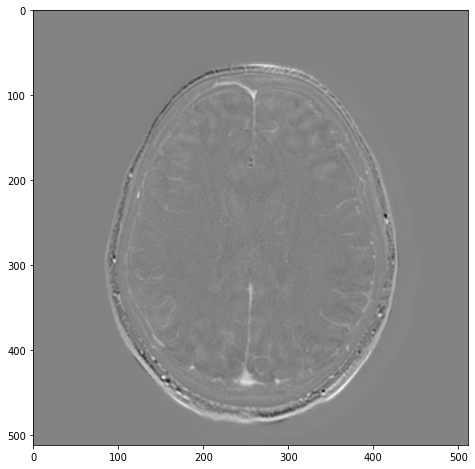

In [27]:
plt.imshow(low_reg[15] - pre_2d[15])

## Train split

In [45]:
df_params = pd.read_csv('/home/srivathsa/projects/studies/gad/gad_2d/data/sim_params.csv', index_col=0)

df_ring = df_params.loc[(df_params['Ringing Artifacts'] == True) & (df_params['Motion Artifacts'] == False)]
df_motion = df_params.loc[(df_params['Ringing Artifacts'] == False) & (df_params['Motion Artifacts'] == True)]
df_both = df_params.loc[(df_params['Ringing Artifacts'] == True) & (df_params['Motion Artifacts'] == True)]

def get_idxs_with_query(df, kw, num):
    query_dict = {
        'p': (df['Pre Augmented'] == True) & (df['Low Augmented'] == False) & (df['Full Augmented'] == False),
        'l': (df['Pre Augmented'] == False) & (df['Low Augmented'] == True) & (df['Full Augmented'] == False),
        'f': (df['Pre Augmented'] == False) & (df['Low Augmented'] == False) & (df['Full Augmented'] == True),
        'pl': (df['Pre Augmented'] == True) & (df['Low Augmented'] == True) & (df['Full Augmented'] == False),
        'pf': (df['Pre Augmented'] == True) & (df['Low Augmented'] == False) & (df['Full Augmented'] == True),
        'lf': (df['Pre Augmented'] == False) & (df['Low Augmented'] == True) & (df['Full Augmented'] == True),
        'plf': (df['Pre Augmented'] == True) & (df['Low Augmented'] == True) & (df['Full Augmented'] == True)
    }

    df_filt = df.loc[query_dict[kw]]
    return np.random.choice(df_filt['Case'].tolist(), size=num, replace=False)

In [46]:
train_cases = []

# ring cases
train_cases.extend(get_idxs_with_query(df_ring, 'p', 9))
train_cases.extend(get_idxs_with_query(df_ring, 'l', 9))
train_cases.extend(get_idxs_with_query(df_ring, 'f', 2))
train_cases.extend(get_idxs_with_query(df_ring, 'pl', 9))
train_cases.extend(get_idxs_with_query(df_ring, 'pf', 2))
train_cases.extend(get_idxs_with_query(df_ring, 'lf', 3))
train_cases.extend(get_idxs_with_query(df_ring, 'plf', 1))

# motion cases
train_cases.extend(get_idxs_with_query(df_motion, 'p', 9))
train_cases.extend(get_idxs_with_query(df_motion, 'l', 9))
train_cases.extend(get_idxs_with_query(df_motion, 'f', 2))
train_cases.extend(get_idxs_with_query(df_motion, 'pl', 9))
train_cases.extend(get_idxs_with_query(df_motion, 'pf', 2))
train_cases.extend(get_idxs_with_query(df_motion, 'lf', 3))
train_cases.extend(get_idxs_with_query(df_motion, 'plf', 1))

# both cases
train_cases.extend(get_idxs_with_query(df_both, 'p', 3))
train_cases.extend(get_idxs_with_query(df_both, 'l', 3))
train_cases.extend(get_idxs_with_query(df_both, 'f', 1))
train_cases.extend(get_idxs_with_query(df_both, 'pl', 2))
train_cases.extend(get_idxs_with_query(df_both, 'pf', 1))
train_cases.extend(get_idxs_with_query(df_both, 'lf', 1))
train_cases.extend(get_idxs_with_query(df_both, 'plf', 1))

train_cases = sorted(train_cases)

In [68]:
exp_data = exp_utils.get_experiment_data(
    'tiantan_2d', dirpath_exp='/home/srivathsa/projects/SubtleGad/train/configs/experiments', dataset='test'
)

ser_dirs = sorted([f.split('/')[-1] for f in glob('/home/srivathsa/projects/studies/gad/gad_2d/data/P*')])

case_nums = []

for cnum in exp_data:
    case_ser = [c for c in ser_dirs if c.startswith(cnum)][0]
    case_nums.append(case_ser)


In [69]:
case_nums

['P0086_2DSIM_P_RNG',
 'P0090_2DSIM',
 'P0095_2DSIM_P_RNG',
 'P0102_2DSIM_P_RNG',
 'P0103_2DSIM_P_MOT',
 'P0104_2DSIM',
 'P0106_2DSIM_P_MOT',
 'P0110_2DSIM_P_MOT',
 'P0124_2DSIM_P_RNG_MOT',
 'P0131_2DSIM_P_RNG',
 'P0133_2DSIM',
 'P0134_2DSIM',
 'P0139_2DSIM_P_RNG',
 'P0162_2DSIM',
 'P0165_2DSIM',
 'P0169_2DSIM',
 'P0172_2DSIM_P_MOT',
 'P0177_2DSIM',
 'P0179_2DSIM_P_MOT',
 'P0183_2DSIM_P_RNG',
 'P0187_2DSIM',
 'P0192_2DSIM_P_MOT',
 'P0200_2DSIM_L_MOT',
 'P0204_2DSIM',
 'P0207_2DSIM_L_MOT',
 'P0208_2DSIM_L_MOT',
 'P0213_2DSIM_P_RNG_MOT',
 'P0214_2DSIM',
 'P0230_2DSIM',
 'P0236_2DSIM',
 'P0238_2DSIM',
 'P0242_2DSIM',
 'P0247_2DSIM_L_RNG',
 'P0253_2DSIM',
 'P0261_2DSIM_L_MOT',
 'P0264_2DSIM_L_RNG',
 'P0265_2DSIM_L_MOT',
 'P0281_2DSIM_L_RNG',
 'P0288_2DSIM_L_RNG_MOT',
 'P0292_2DSIM_L_RNG',
 'P0294_2DSIM',
 'P0299_2DSIM',
 'P0303_2DSIM',
 'P0304_2DSIM',
 'P0307_2DSIM_L_MOT',
 'P0314_2DSIM_L_RNG',
 'P0319_2DSIM',
 'P0325_2DSIM',
 'P0328_2DSIM_L_RNG_MOT',
 'P0340_2DSIM',
 'P0346_2DSIM_F_MOT',


In [10]:
train_data = exp_utils.get_experiment_data(
    'tiantan_2d', dirpath_exp='/home/srivathsa/projects/SubtleGad/train/configs/experiments', dataset='train'
)

val_data = exp_utils.get_experiment_data(
    'tiantan_2d', dirpath_exp='/home/srivathsa/projects/SubtleGad/train/configs/experiments', dataset='val'
)

for c in val_data:
    print('ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/{} /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;'.format(c))

ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0099_2DSIM_P_RNG /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;
ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0107_2DSIM_P_MOT /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;
ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0118_2DSIM_P_RNG /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;
ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0145_2DSIM_P_RNG /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;
ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0151_2DSIM_P_MOT /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;
ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0152_2DSIM /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;
ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0157_2DSIM /home/srivathsa/projects/studies/gad/gad_2d/data/val_tmp/;
ln -s /home/srivathsa/projects/studies/gad/gad_2d/data/P0174_2DSIM_P_MOT /home/srivathsa

(-0.5, 1023.5, 511.5, -0.5)

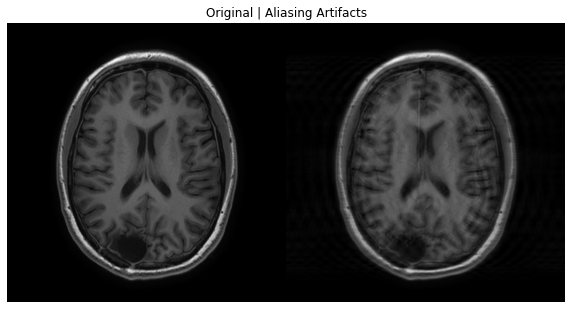

In [12]:
orig_ip = get_dicom_vol('/home/srivathsa/projects/studies/gad/gad_2d/data/clean/P0225_2DSIM/15_AX_BRAVO_+C_Pre_Load_10')
alias_ip = get_dicom_vol('/home/srivathsa/projects/studies/gad/gad_2d/data/aug/both/P0225_2DSIM_L_RNG_MOT/15_AX_BRAVO_+C_Pre_Load_10')

sl = orig_ip.shape[0] // 2

disp_img = np.hstack([orig_ip[sl], alias_ip[sl]])
plt.imshow(disp_img)
plt.title('Original | Aliasing Artifacts')
plt.axis('off')